In [1]:
import auction_data, os, analytics
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('white')
%matplotlib inline

## auction analysis packages
- `auction_data` provides tools to access, compute statistics of interest, and manipulate procurement auction data
- `analytics` provides tools to setup and solve a variety of safe tests as described in 

    ''Data-Driven Regulation: Theory and Application to Missing Bids'' (Chassang, Kawai, Nakabayashi and Ortner)

### `auction_data`

First, we'll use `auction_data` to plot the distribution of winning margins, as well as the aggregate demand for auctions in the Tsuchiura dataset.

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

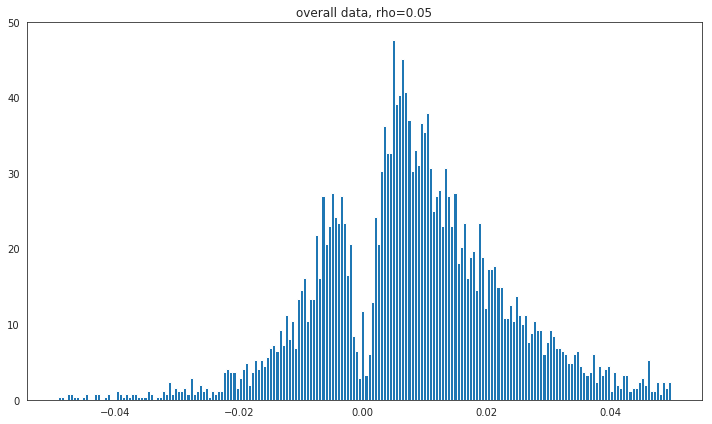

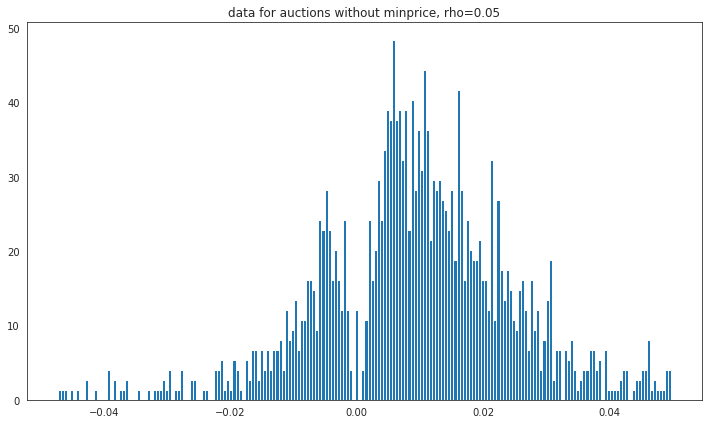

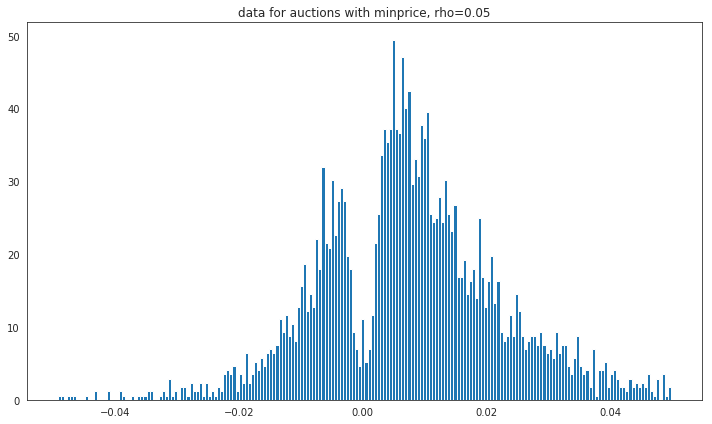

In [3]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta,'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data._raw_data.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data._raw_data.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

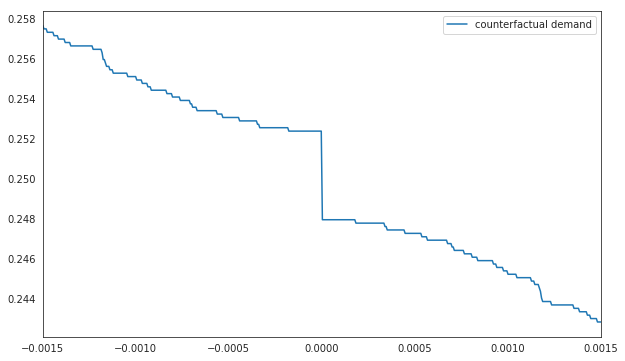

In [4]:
tsuchiura_data.demand_function(-.0015, .0015).plot(figsize = (10,6))

## analytics

Next, we use `analytics` to compute the minimum number of non-competitive histories, as well as the minimum normalized deviation temptation corresponding to deviations $[-.02, -.0001, 0, .0005]$

In [5]:
deviations = [-.02, -.0001, .0, .0005]
demands = [tsuchiura_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6938393464942137, 0.25238257317903334, 0.25017018379850237, 0.24727705922396187]


In [6]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

In [7]:
# note: here without projection, many environments are eliminated before optimization

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))
print('collusion-minimizing distribution: \n{}'.format(min_collusion_solver.argmin.head()))

minimum share of collusive histories: 0.6589650776955307
collusion-minimizing distribution: 
           prob     -0.02   -0.0001       0.0    0.0005      cost  metric
0  2.888083e-11  0.787477  0.339633  0.251704  0.225063  0.959697     1.0
1  5.508395e-12  0.585258  0.327436  0.322952  0.203787  0.745305     1.0
2  6.183299e-12  0.579331  0.341231  0.304976  0.216448  0.943986     1.0
3  4.335791e-11  0.718680  0.278742  0.191123  0.178265  0.670876     1.0
4  1.645203e-11  0.590439  0.310815  0.296753  0.212389  0.677542     1.0


In [8]:
# note: here with projection, no environments are eliminated before optimization
# as a result we get a better solution even though we are sampling less points

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e4,
    seed=5,
    project=True
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))
print('collusion-minimizing distribution: \n{}'.format(min_collusion_solver.argmin.head()))

minimum share of collusive histories: 0.4340260698286074
collusion-minimizing distribution: 
           prob     -0.02   -0.0001       0.0    0.0005      cost  metric
0  5.734790e-12  0.781296  0.350104  0.199200  0.192844  0.729472     1.0
1  4.544004e-12  0.713227  0.278331  0.264472  0.166451  0.995208     1.0
2  4.472550e-12  0.772648  0.333267  0.318022  0.214128  0.667405     1.0
3  6.776627e-12  0.770965  0.322791  0.319475  0.275290  0.686607     1.0
4  1.505008e-11  0.645586  0.226592  0.193765  0.191029  0.893061     1.0


## expected properties

In [9]:
# minimum collusion goes down as k gets bigger
constraints = [analytics.MarkupConstraint(max_markup=2),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

minimum share of collusive histories: 0.6484859288491327


In [10]:
# minimum collusion goes down as the maximum markup gets bigger

constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.75, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

minimum share of collusive histories: 0.23962018867022725


In [11]:
# minimum collusion goes up when the gap in the distribution of bid differences gets bigger

df_bids = tsuchiura_data.df_bids
df_bids = df_bids.loc[tsuchiura_data._raw_data.minprice.isnull()]
delta = delta[delta.between(-rho, rho)]

tsuchiura_no_minprice_data = auction_data.AuctionData(df_bids)

In [12]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_no_minprice_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

minimum share of collusive histories: 0.6841305387786824


## some issues

The main issue is that the quality of the solution still changes significantly as we vary 
the seed or the sampling strategy

In [13]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

for seed in [1, 5]:
    for project in [False, True]:
        num_points = 1e6 * (1 - project) + 1e4 * project
        print(20*'=' + '\n'
              + 'seed={}, project={}, num_points={}'.format(seed, project, num_points))
        
        min_collusion_solver = analytics.MinCollusionSolver(
            data=tsuchiura_data,
            deviations=deviations,
            tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
            metric=analytics.IsNonCompetitive,
            plausibility_constraints=constraints,
            num_points=num_points,
            seed=seed,
            project=project
        )
        
        print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

seed=1, project=False, num_points=1000000.0
minimum share of collusive histories: 0.5202263465075648
seed=1, project=True, num_points=10000.0
minimum share of collusive histories: 0.22760282071728652
seed=5, project=False, num_points=1000000.0
minimum share of collusive histories: 0.6589650776955307
seed=5, project=True, num_points=10000.0
minimum share of collusive histories: 0.4340260698286074


## potential solution to the convergence problem

One potential solution, along the lines of simulated annealing would be to iterate on imperfect solutions,
seeding the sample space with solutions obtained at previous stages. 

This would hopefully let us focus on the important parts of the solution space

In [15]:
# indeed, in a typical solution, the solution puts meaningful mass only on a few points

highest_weight_points = min_collusion_solver.argmin.sort_values('prob', ascending=False).iloc[:10]
print(highest_weight_points)
highest_weight_points.prob.sum()

             prob     -0.02   -0.0001       0.0    0.0005      cost  metric
51   5.659739e-01  0.776813  0.307261  0.303464  0.269570  0.992379     0.0
506  4.309337e-01  0.604349  0.188413  0.184989  0.181021  0.946199     1.0
132  3.092308e-03  0.719514  0.291438  0.284748  0.279929  0.724505     1.0
293  3.794694e-09  0.702672  0.278932  0.274792  0.266255  0.792012     1.0
524  2.788276e-09  0.754375  0.326228  0.313915  0.309958  0.695638     1.0
162  2.169633e-09  0.728223  0.257095  0.254519  0.222263  0.990880     0.0
92   2.410376e-10  0.663915  0.243294  0.238704  0.231781  0.793275     1.0
164  9.347157e-11  0.608834  0.187659  0.184434  0.179343  0.901133     1.0
254  6.557257e-11  0.769196  0.328764  0.324228  0.317375  0.892137     1.0
542  4.621246e-11  0.607054  0.191450  0.183248  0.175139  0.687000     1.0


0.9999999947864653